In [1]:
import ctypes
import os
import threading
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
matplotlib.style.use('ggplot')
import math
import concurrent.futures
import glob
import json
import scipy as sp
import scipy.special
from matplotlib.ticker import FormatStrFormatter
from itertools import chain

In [7]:
data_mode = 'CA'

In [8]:
test_mode = 'Apr-25-2017/EEModel/RelBaseLearn08/'
test_name = 'RelBaseLearn08'

In [9]:
names = ['P_total', 'P_hard', 'P_soft', 'tick', 'uid']

In [14]:
N_SIMULATION_TICKS = 20

In [15]:
N_TICKS_DISPLAY = 15

In [10]:
#read few files
#save into database
dfs_ = []
#read last simulation result
files = glob.glob('/Users/wilfeli/Dropbox/ABM/SolarPanels/ABMIRISLab/Saves/' + test_mode + data_mode + '/*[_pv].csv')
files.sort(key=os.path.getmtime, reverse=True)


In [11]:
print(len(files))

100


In [12]:
indexing_range = range(0,100)


#take top x files 
for file in [files[i] for i in indexing_range]:
    df_ = pd.read_csv(file, names=names, \
                      low_memory=False, \
                     na_values = ['-nan(ind)'])
    df_['share_hard_costs'] = df_['P_hard']/df_['P_total']
    dfs_.append(df_)

In [16]:
df_ress_ = []
index_res = range(N_SIMULATION_TICKS)
names_res = ['tick']    
for i in range(3):
    names_res.append('sei_' + str(i) + '_share_hard_costs')
        
for df_ in dfs_:
    
    df_res_ = pd.DataFrame(columns=names_res, index=index_res)
    df_res_['tick'] = range(N_SIMULATION_TICKS)
    
    i = 0 
    for uid in df_['uid'].value_counts().index.sort_values():
        index = df_['uid'] == uid

        #for each tick - average for share = group by tick and use mean 
        #reindex that all ticks are there - see drawing graphs with bins 
        
        df = df_[index == True].groupby(df_['tick']).mean()
       
        #add missing ticks 
        df = df.reindex(range(N_SIMULATION_TICKS), fill_value=np.NaN)
        
        #need uid -> column name 
        df_res_['sei_' + str(i) + '_share_hard_costs'] = df['share_hard_costs']
        i = i + 1
        
        #have tick - share for uid
        #need tick - share for uids in increasing order
        
        df_ress_.append(df_res_)
        

df_concat = pd.concat(df_ress_)
df = df_concat.groupby(level=0).mean()
df_std = df_concat.groupby(level=0).std()

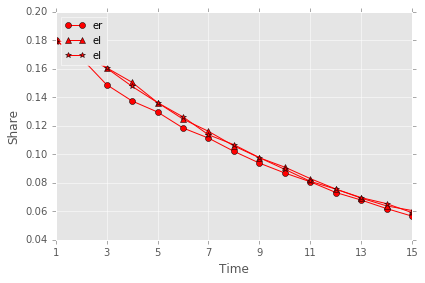

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.subplots_adjust(right=0.85)

axes = [axes]

#par1 = axes[0].twinx()

ind = df.index.values[0:N_TICKS_DISPLAY] + 1



agents_to_show = ['sei_' + str(i) + '_share_hard_costs' for i in range(3)]
markers = ["-ro", "-r^", "-r*"]
colors = ['r', 'r', 'r']
labels = ["er", "el", "el"]

i = 0
lines = []

for agent in agents_to_show:
    pi, = axes[0].plot(ind, df[agent][0:N_TICKS_DISPLAY], markers[i], label=labels[i])
    lines.append(pi)
    i = i + 1

    
axes[0].legend(lines, [l.get_label() for l in lines], fontsize='10', loc=2)
    
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Share")
#axes[0].set_title('...', fontsize=10)

start = 1
end = 16
axes[0].set_autoscaley_on(False)
axes[0].set_xlim([1,15])
#axes[0].set_ylim([0, 45])
axes[0].xaxis.set_ticks(np.arange(start, end, 2))

plt.tight_layout()
plt.savefig('Simulation_results_share_' + data_mode + '_' + test_name +'.png', dpi=300)
plt.show()